## Assignment: Aspect-Based Emotion Detection - Dataset: https://www.kaggle.com/datasets/lazaro97/the-last-of-us-reviews

In [26]:
##imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import re
import gensim.downloader as api
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator
from sklearn.metrics import classification_report
import nltk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from collections import defaultdict

nltk.download('punkt')
pd.set_option('display.max_colwidth',None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
##dataset combining and loading
file_names = [
    'critic_reviews_g1.csv',
    'critic_reviews_g1u.csv',
    'critic_reviews_g2.csv',
    'critic_reviews_lb.csv',
    'user_reviews_g1.csv',
    'user_reviews_g1u.csv',
    'user_reviews_g2.csv',
    'user_reviews_g2u.csv',
    'user_reviews_lb.csv'
]

dataframes = []

for file_name in file_names:
    df = pd.read_csv(file_name)  
    dataframes.append(df)  

combined_df = pd.concat(dataframes, ignore_index=True)

(combined_df.head())



,id,review,date,score,platform,type_review,language,views,votes,split
0,Cubed3,"A post-apocalyptic road trip that offers a fantastic, riveting experience, where destruction and beauty, and hope and despair, get entwined in a way that’s nothing short of genius, The Last of Us is so good that its somewhat repetitive, and occasionally dull gameplay isn’t enough to rob it of its rightful place amongst the video game greats. Therefore, if looking for an unforgettable action-adventure, with strong cinematic sensibilities, and a heavy emphasis in adult, character-driven storytelling, look no further than Naughty Dog’s classic, especially now that the remastered version has made the original even more stunning.",2020-07-28,90.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"Visual improvements and three included DLCs don’t justify buying this game again, but if you haven’t played it on PS3 yet, you’re in for long hours of valuable entertainment. [Sept 2014, p.59]",2014-10-22,80.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,One of the best titles of the previous generation is now available in all the next-gen glory and also with all the DLCs. Take it or leave it. [Issue#245],2014-10-13,100.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"For the most part, the mind-blowing experience you remember with true new-gen visuals. No PS4 library is complete without this. [October 2014, p70]",2014-09-19,100.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Eurogamer Portugal,"The Last of Us is one of the easiest games to recommend to any player, from the ones who like to occasionally play to the hardcore that want to explore everything. The release of The Last of Us: Remastered makes its acquisition even more attractive game and remembers those who have not played that it’s not too late to know this landmark in video game history.",2014-09-05,100.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
##dropping unecessary columns
combined_df.drop(columns=['date','score','platform','type_review','language','views','votes','split'],inplace=True)

In [12]:
##taking a small sample of the df for computational limitations
df = combined_df.sample(n=100)

##using google translator to translate the english sentences
translator = GoogleTranslator(source='en', target='ar')
google_translations = [translator.translate(sentence) for sentence in df['review']]


In [13]:
##creating a df for the translated reviews
df = pd.DataFrame({
    'English reviews': df['review'],
    'Arabic reviews': google_translations
})
df.reset_index(inplace=True,drop=True)

In [14]:
df.head()

,English reviews,Arabic reviews
0,"Muito ruim, sério o final desse jogo é o pior dos jogos triplo A de todos os tempos, nada faz sentido e o desrespeito sobre os protagonistas e jogadores do primeiro é gigantesca. Esse jogo tem uma lacração tão forçada que vai te fazer vomitar. 0/10 pq a gameplay e os gráficos são bons mas a história é tão RUIM que acabou pesando imensamente nessa análise",الكثير من الوقت، سلسلة أو نهائية من اللعبة هي أفضل لعبتين ثلاثية في جميع الأوقات، لا شيء يشعر بها ولا ينقصها شعور بالأبطال وملاعبي أول مرة عملاقة. هذه اللعبة تحتوي على دمع يفرض عليك القيء. 0/10 جزء من اللعب والرسومات أفضل من التاريخ هو RUIM الذي لا يتم تحليله بشكل كبير
1,"One of the worst games I’ve ever played, this fame has motivated me to turn in my ps4 and all my video games. Very slow in the beginning, doesn’t feel like a new game, feels like an expansion of the first. Poor narrative designs really big this game down. 0/10",واحدة من أسوأ الألعاب التي لعبتها على الإطلاق، وقد شجعتني هذه الشهرة على التخلي عن جهاز PS4 وجميع ألعاب الفيديو التي أملكها. اللعبة بطيئة للغاية في البداية، ولا تبدو وكأنها لعبة جديدة، بل تبدو وكأنها توسعة للعبة الأولى. تصميمات السرد الرديئة تجعل هذه اللعبة سيئة للغاية. 0/10
2,"이 씨1발 니 이름은 이제부터 pc트럭이야 이 갯샠이야,,스토리 중심 게임에서 스토리를 예술병 처걸린 상태로 쓰는게 정상이냐 이 개같은,,1 플레이한 유저들 기만한거야 넌,,폭풍전야 같은 새끼야",تم إنشاء هذا التطبيق رقم 1 على جهاز كمبيوتر شخصي،، وهو عبارة عن جهاز كمبيوتر شخصي قم بتمديد الوقت الذي يستغرقه الأمر،، 1 أسبوع من العمل في المنزل،،السفر 같은 새끼야
3,"This game will try to emotionally break you. Questionable scenario, but brilliant from all technicals sides. The best game to play for the last couple of years.",ستحاول هذه اللعبة أن تكسرك عاطفيًا. سيناريو مثير للشكوك، لكنه رائع من جميع النواحي الفنية. إنها أفضل لعبة يمكنك لعبها خلال العامين الماضيين.
4,"For me the story was perfect. It's so interesting that in the first game they established joel and ellie as sympathetic characters, but not necessarily loveable. joel is made apathetic by grief and ellie's naive and a bit awkward; regardless, we grow to love them for all their complexities. in the end, joel makes a terrible decision that's the right one for him, and the audience may not agree but /everyone/ understands him, and most forgive it because they love him and ellie.,In this game, they took loveable characters and said yes, they're sympathetic, but they're not the heroes and you're not going to forget it. and honestly? that's incredible writing, because it /hurts/. it would've been so easy to tell a similar story with characters we don't know so it doesn't 'ruin' ellie and joel, but that's the point- we feel it because they matter to us, this whole game is so personal to gamers because of the successes of the first game. we're invested, we care, we want them to live and we want them to be happy and that's not what this story is. they're complex, they're traumatised, they make bad choices. but they love each other. we love them.,No one has to like this game, but no one can say they don't feel anything while playing it.,**** the haters","بالنسبة لي كانت القصة مثالية. من المثير للاهتمام أنه في اللعبة الأولى، جعلوا من جويل وإيلي شخصيتين متعاطفتين، لكنهما ليسا محبوبتين بالضرورة. أصبح جويل غير مبالٍ بسبب الحزن وسذاجة إيلي وغرابتها بعض الشيء؛ بغض النظر عن ذلك، أصبحنا نحبهما على الرغم من كل تعقيداتهما. في النهاية، اتخذ جويل قرارًا فظيعًا كان القرار الصحيح بالنسبة له، وقد لا يتفق الجمهور معه ولكن /الجميع/ يفهمونه، ومعظمهم يسامحونه لأنهم يحبونه وإيلي. في هذه اللعبة، أخذوا شخصيات محبوبة وقالوا نعم، إنها متعاطفة، لكنهم ليسوا الأبطال ولن تنسى ذلك. وبصراحة؟ هذه كتابة لا تصدق، لأنها /مؤلمة/. كان من السهل جدًا سرد قصة مماثلة بشخصيات لا نعرفها حتى لا ""تدمر"" إيلي وجويل، لكن هذه هي النقطة - نشعر بها لأنهم مهمون بالنسبة لنا، هذه اللعبة بأكملها شخصية للغاية بالنسبة للاعبين بسبب نجاحات اللعبة الأولى. نحن نستثمر فيهم، ونهتم بهم، ونريد لهم أن يعيشوا ونريد لهم أن يكونوا سعداء، وهذه ليست القصة. إنهم معقدون، ومصدومون، ويتخذون خيارات سيئة. لكنهم يحبون بعضهم البعض. نحن نحبهم. لا أحد مضطر إلى ا

In [15]:
##dropping null values if any and tokenization
reviews = df['Arabic reviews'].dropna()  


df['tokens'] = df['Arabic reviews'].apply(lambda x: word_tokenize(x))


##### Using ARAbert with k-means to classify the reviews

In [25]:
##calling arabert model
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [17]:
## dense vectors embeddings using ARAbert 
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding

In [18]:
##calling the function and getting the embeddings for each review + concatting into a tensor
embeddings = [get_embedding(sentence) for sentence in df['Arabic reviews']]
embeddings = torch.cat([torch.tensor(emb) for emb in embeddings])

In [20]:
##calling k-means for unsupervised classification
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)

cluster_labels = kmeans.labels_

C:\Users\moham\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\moham\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [29]:
##data set creation
emotions_classified = pd.DataFrame({
    'Arabic Review': df['Arabic reviews'],  
    'Cluster': cluster_labels             
})

emotions_classified.head()

,Arabic Review,Cluster
0,الكثير من الوقت، سلسلة أو نهائية من اللعبة هي أفضل لعبتين ثلاثية في جميع الأوقات، لا شيء يشعر بها ولا ينقصها شعور بالأبطال وملاعبي أول مرة عملاقة. هذه اللعبة تحتوي على دمع يفرض عليك القيء. 0/10 جزء من اللعب والرسومات أفضل من التاريخ هو RUIM الذي لا يتم تحليله بشكل كبير,1
1,واحدة من أسوأ الألعاب التي لعبتها على الإطلاق، وقد شجعتني هذه الشهرة على التخلي عن جهاز PS4 وجميع ألعاب الفيديو التي أملكها. اللعبة بطيئة للغاية في البداية، ولا تبدو وكأنها لعبة جديدة، بل تبدو وكأنها توسعة للعبة الأولى. تصميمات السرد الرديئة تجعل هذه اللعبة سيئة للغاية. 0/10,1
2,تم إنشاء هذا التطبيق رقم 1 على جهاز كمبيوتر شخصي،، وهو عبارة عن جهاز كمبيوتر شخصي قم بتمديد الوقت الذي يستغرقه الأمر،، 1 أسبوع من العمل في المنزل،،السفر 같은 새끼야,2
3,ستحاول هذه اللعبة أن تكسرك عاطفيًا. سيناريو مثير للشكوك، لكنه رائع من جميع النواحي الفنية. إنها أفضل لعبة يمكنك لعبها خلال العامين الماضيين.,1
4,"بالنسبة لي كانت القصة مثالية. من المثير للاهتمام أنه في اللعبة الأولى، جعلوا من جويل وإيلي شخصيتين متعاطفتين، لكنهما ليسا محبوبتين بالضرورة. أصبح جويل غير مبالٍ بسبب الحزن وسذاجة إيلي وغرابتها بعض الشيء؛ بغض النظر عن ذلك، أصبحنا نحبهما على الرغم من كل تعقيداتهما. في النهاية، اتخذ جويل قرارًا فظيعًا كان القرار الصحيح بالنسبة له، وقد لا يتفق الجمهور معه ولكن /الجميع/ يفهمونه، ومعظمهم يسامحونه لأنهم يحبونه وإيلي. في هذه اللعبة، أخذوا شخصيات محبوبة وقالوا نعم، إنها متعاطفة، لكنهم ليسوا الأبطال ولن تنسى ذلك. وبصراحة؟ هذه كتابة لا تصدق، لأنها /مؤلمة/. كان من السهل جدًا سرد قصة مماثلة بشخصيات لا نعرفها حتى لا ""تدمر"" إيلي وجويل، لكن هذه هي النقطة - نشعر بها لأنهم مهمون بالنسبة لنا، هذه اللعبة بأكملها شخصية للغاية بالنسبة للاعبين بسبب نجاحات اللعبة الأولى. نحن نستثمر فيهم، ونهتم بهم، ونريد لهم أن يعيشوا ونريد لهم أن يكونوا سعداء، وهذه ليست القصة. إنهم معقدون، ومصدومون، ويتخذون خيارات سيئة. لكنهم يحبون بعضهم البعض. نحن نحبهم. لا أحد مضطر إلى الإعجاب بهذه اللعبة، لكن لا أحد يستطيع أن يقول إنه لا يشعر بأي شيء أثناء لعبها.",1


In [30]:
##dimensionality reduction for visualizing the clusters
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

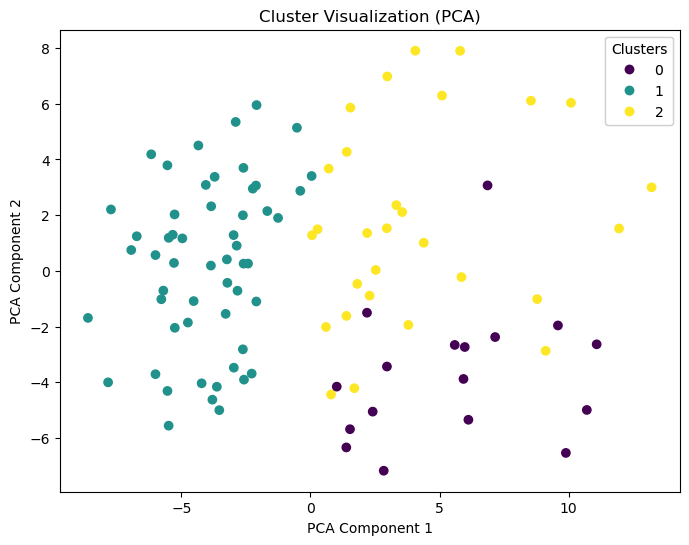

In [27]:
##cluster visuals
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')

legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

##### I would like to highlight the following: I took the approach of unsupervised learning with a dataset that is not labelled, creating an embedding using arabert and then clusterring based on that embedding. This approach allows us to tackle more robust datasets, that are not labelled, which is usually the case. While I could've used the score variable and create a rule-based script to label the data, this can be extended on later. My approach focuses on establishing an understanding on unlabelled datasets and our ability to extract most info using a combination of different algorithms, while also successively achieving the goal of identifying/classifying for respective emotions.